In [1]:
import parselmouth as pm
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import fasttrackpy.tracking
import scipy.fft
from IPython.display import Image
import time

## First pass

In [2]:
sound = pm.Sound("assets/ay.wav")

In [3]:
print([x for x in dir(sound) if "__" not in x])

['FileFormat', 'ToHarmonicityMethod', 'ToPitchMethod', 'add', 'as_array', 'at_xy', 'autocorrelate', 'centre_time', 'class_name', 'combine_to_stereo', 'concatenate', 'convert_to_mono', 'convert_to_stereo', 'convolve', 'copy', 'cross_correlate', 'de_emphasize', 'deepen_band_modulation', 'divide', 'dt', 'duration', 'dx', 'dy', 'end_time', 'extract_all_channels', 'extract_channel', 'extract_left_channel', 'extract_part', 'extract_part_for_overlap', 'extract_right_channel', 'formula', 'frame_number_to_time', 'full_name', 'get_column_distance', 'get_end_time', 'get_energy', 'get_energy_in_air', 'get_frame_number_from_time', 'get_highest_x', 'get_highest_y', 'get_index_from_time', 'get_intensity', 'get_lowest_x', 'get_lowest_y', 'get_maximum', 'get_minimum', 'get_nearest_zero_crossing', 'get_number_of_channels', 'get_number_of_columns', 'get_number_of_frames', 'get_number_of_rows', 'get_number_of_samples', 'get_power', 'get_power_in_air', 'get_rms', 'get_root_mean_square', 'get_row_distance',

In [4]:
formants = sound.to_formant_burg(time_step = 0.001,
                                 max_number_of_formants = 6, 
                                 maximum_formant = 5000,
                                 window_length = 0.025,
                                 pre_emphasis_from = 50)

In [5]:
print([x for x in dir(formants) if "__" not in x])

['FileFormat', 'centre_time', 'class_name', 'copy', 'dt', 'duration', 'dx', 'end_time', 'frame_number_to_time', 'full_name', 'get_bandwidth_at_time', 'get_end_time', 'get_frame_number_from_time', 'get_number_of_frames', 'get_start_time', 'get_time_from_frame_number', 'get_time_step', 'get_total_duration', 'get_value_at_time', 'info', 'n_frames', 'name', 'nt', 'nx', 'read', 'save', 'save_as_binary_file', 'save_as_short_text_file', 'save_as_text_file', 'scale_times_by', 'scale_times_to', 'scale_x_by', 'scale_x_to', 'shift_times_by', 'shift_times_to', 'shift_x_by', 'shift_x_to', 'start_time', 't1', 't_bins', 't_grid', 'time_range', 'time_step', 'time_to_frame_number', 'tmax', 'tmin', 'total_duration', 'trange', 'ts', 'x1', 'x_bins', 'x_grid', 'xmax', 'xmin', 'xrange', 'xs']


In [6]:
time_domain = formants.xs()

In [7]:
f1 = np.array([formants.get_value_at_time(1, x) for x in time_domain])
f2 = np.array([formants.get_value_at_time(2, x) for x in time_domain])

In [8]:
tracks = np.array(
        [
            [formants.get_value_at_time(i+1, x) 
                for x in time_domain] 
            for i in range(6)
        ]
    )
tracks.shape

(6, 769)

In [9]:
formant_data = pd.DataFrame(
    {"f1": f1,
     "f2": f2,
     "t": time_domain
    }
)

In [10]:
track_plot = px.line(formant_data, x = "t", y = ["f1", "f2"])
track_plot.show()

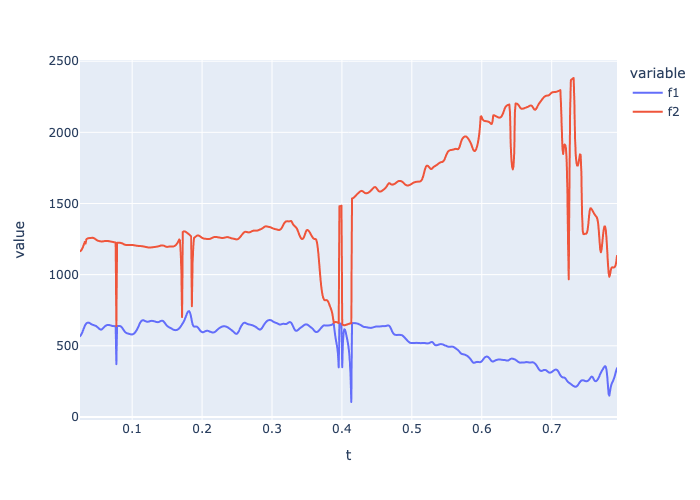

In [11]:
## static version
track_plot_bytes = track_plot.to_image(format="png")
Image(track_plot_bytes)

## With fasttrackpy code

In [12]:
tracked = fasttrackpy.tracking.findformants(sound=sound,
                                 time_step = 0.001,
                                 n_formants = 6, 
                                 maximum_formant = 5000,
                                 window_length = 0.025,
                                 pre_emphasis_from = 50)
tracked.shape

(6, 769)

In [13]:
formant_df = pd.DataFrame({"f1" : tracked[0], "f2" : tracked[1], "t" : time_domain})
formant_df

,f1,f2,t
0,567.192389,1164.183902,0.025406
1,573.631406,1167.431455,0.026406
2,581.554070,1172.692369,0.027406
3,591.472499,1180.737646,0.028406
4,603.382443,1191.824915,0.029406
...,...,...,...
764,274.864856,1051.248536,0.789406
765,291.363797,1055.360784,0.790406
766,310.170734,1066.354259,0.791406
767,328.256330,1090.826708,0.792406


In [14]:
track_plot2 = px.line(formant_df, x = "t", y = ["f1", "f2"])
track_plot2.show()

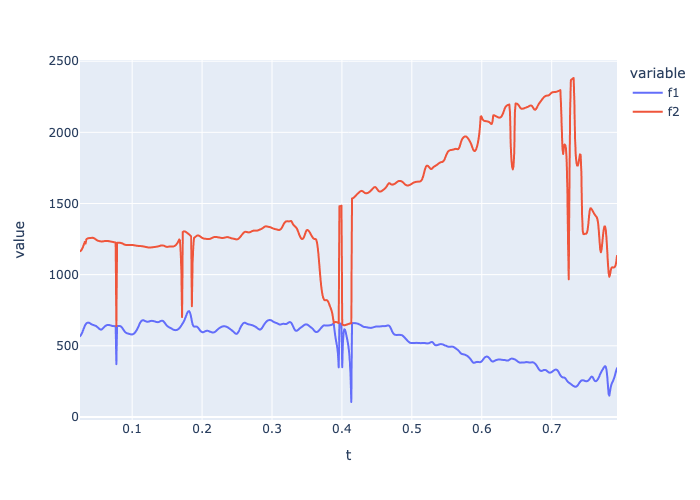

In [15]:
## static version
track_plot2_bytes = track_plot2.to_image(format="png")
Image(track_plot2_bytes)

## Smoothing experiment

In [16]:
f1_dct = scipy.fft.dct(f1)
f1_fit = scipy.fft.idct(f1_dct[0:5], n = f1.shape[0])
f2_dct = scipy.fft.dct(f2)
f2_fit = scipy.fft.idct(f2_dct[0:5], n = f2.shape[0])

In [17]:
smooth_df = pd.DataFrame(
    {"f1" : f1, 
     "f1_smooth" : f1_fit,
     "f2" : f2,
     "f2_smooth" : f2_fit,
     "t" : time_domain}
)

In [18]:
smooth_plot = px.line(
    smooth_df,
    x = "t",
    y = ["f1", "f2", "f1_smooth", "f2_smooth"]
)
smooth_plot.show()

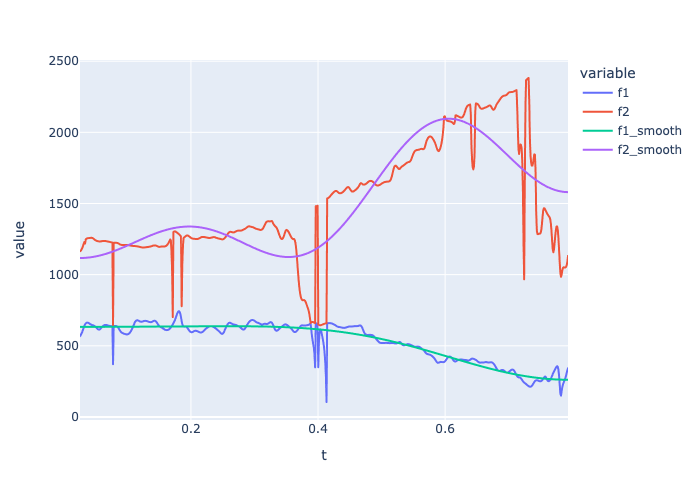

In [19]:
## static version
smooth_plot_bytes = smooth_plot.to_image(format="png")
Image(smooth_plot_bytes)

I'll try applying a smoother across a numpy axis?

In [20]:
tracked_array = tracked[0:4, :, np.newaxis]
tracked_array.shape

(4, 769, 1)

In [21]:
def smooth_fun(x, order = 5):
    coefs = scipy.fft.dct(x)
    coef_subset = coefs[0:order]
    smooth = scipy.fft.idct(coef_subset, n = x.shape[0])
    return(smooth)

def smooth_formants(formants, 
                    smooth_fun, 
                    axis = 1, 
                    **kwargs):
    """
    Given a formants array, smooth it according to smooth_fun
    """
    smoothed = np.apply_along_axis(smooth_fun, axis, formants,  **kwargs)
    return(smoothed)    

In [22]:
smoothed = np.apply_along_axis(smooth_fun, 1, tracked_array, **{"order":5})

Trying it again, with fasttrackpy

In [23]:
smooth_fun = fasttrackpy.tracking.dct_smooth
smoothed = fasttrackpy.tracking.smooth_formants(tracked_array, smooth_fun)

In [24]:
ft_smooth_plot = px.line(x = time_domain, y=[tracked_array[0,:,0], smoothed[0, :, 0]])
ft_smooth_plot.show()

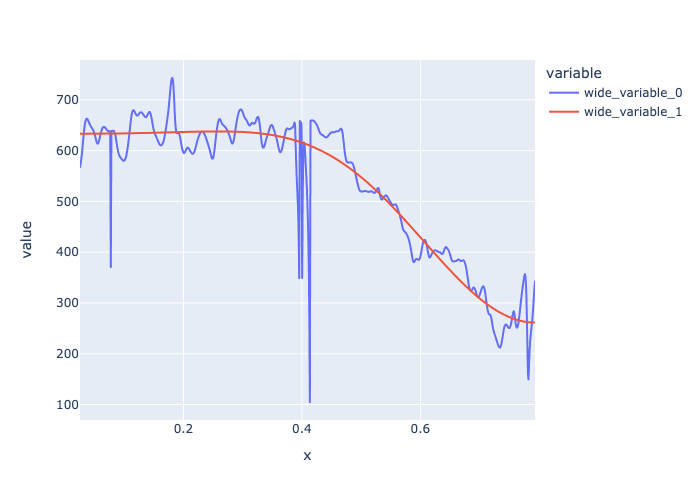

In [25]:
## static version
ft_smooth_plot_bytes = ft_smooth_plot.to_image(format="png")
Image(ft_smooth_plot_bytes)

## Calculating error

In [26]:
loss_fun = fasttrackpy.tracking.lmse
agg_fun = fasttrackpy.tracking.agg_sum

In [27]:
fasttrackpy.tracking.smooth_error(tracked_array, smoothed, loss_fun, agg_fun)

array([0.06729916])

## Multiple max formants

To see if the smooth error functions are working properly, I need to get multiple formant estimates

In [28]:
max_formants = np.linspace(5000, 7000, num = 20)
max_formants.shape

(20,)

In [29]:
start1 = time.time()

formant_arrays = [
    fasttrackpy.tracking.findformants(sound=sound,
                                 time_step = 0.001,
                                 n_formants = 6, 
                                 maximum_formant = x,
                                 window_length = 0.025,
                                 pre_emphasis_from = 50)
    for x in max_formants
]
formant_candidates = np.stack(formant_arrays, axis = -1)

end1 = time.time()
end1 - start1

0.5641748905181885

In [30]:
start2 = time.time()

find_args = {"sound": sound,
             "time_step": 0.001,
             "n_formants": 6,
             "window_length": 0.025,
             "pre_emphasis_from" : 50}
formant_candidates2 = np.apply_along_axis(fasttrackpy.tracking.findformants, 1, max_formants[:,np.newaxis], **find_args)
end2 = time.time()

end2-start2

0.5598597526550293

No real speed advantages. The list comprehension & stacking is probably more legible?

In [31]:
formant_candidates.shape

(6, 769, 20)

In [32]:
eval_candidates = formant_candidates[0:4, :, :]
eval_candidates.shape

(4, 769, 20)

In [33]:
smooth_fun = fasttrackpy.tracking.dct_smooth
smoothed = fasttrackpy.tracking.smooth_formants(eval_candidates, smooth_fun)

In [34]:
smoothed.shape

(4, 769, 20)

In [35]:
f1_smooths = px.line(x = time_domain, y = list(smoothed[0, :, :].T))
f1_smooths.show()

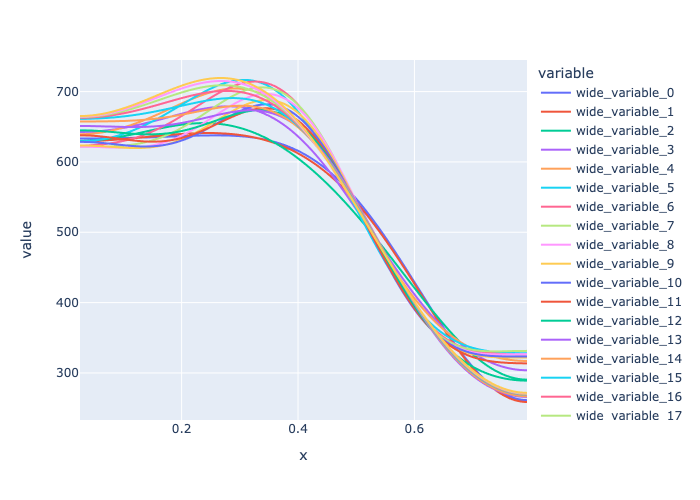

In [36]:
f1_smooths_byte = f1_smooths.to_image(format = "png")
Image(f1_smooths_byte)

With fasttrack code now

In [40]:
all_candidates = fasttrackpy.tracking.all_tracks(sound, n_formants=6)
all_candidates.shape

(6, 769, 20)

In [41]:
eval_candidates = all_candidates[0:4, :, :]

In [44]:
smooth_fun = fasttrackpy.tracking.dct_smooth
smoothed = fasttrackpy.tracking.smooth_formants(eval_candidates, smooth_fun)

In [48]:
loss_fun = fasttrackpy.tracking.lmse
agg_fun = fasttrackpy.tracking.agg_sum
mses = fasttrackpy.tracking.smooth_error(eval_candidates, smoothed, loss_fun, agg_fun)
mses.shape

(20,)

In [51]:
winner_idx = np.argmin(mses)

In [54]:
winner_track = eval_candidates[:, :, winner_idx]
winner_smooth = smoothed[:, :, winner_idx]

In [71]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=time_domain, y=winner_track[0,:],
                    mode='markers',
                    name='f1'))
fig.add_trace(go.Scatter(x=time_domain, y=winner_track[1,:],
                    mode='markers',
                    name='f2'))
fig.add_trace(go.Scatter(x=time_domain, y=winner_track[2,:],
                    mode='markers',
                    name='f3'))                    
fig.add_trace(go.Scatter(x=time_domain, y=winner_smooth[0,:],
                    mode='lines',
                    name='f1_smooth'))
fig.add_trace(go.Scatter(x=time_domain, y=winner_smooth[1,:],
                    mode='lines',
                    name='f2_smooth'))
fig.add_trace(go.Scatter(x=time_domain, y=winner_smooth[2,:],
                    mode='lines',
                    name='f3_smooth'))                                        
fig.show()                    

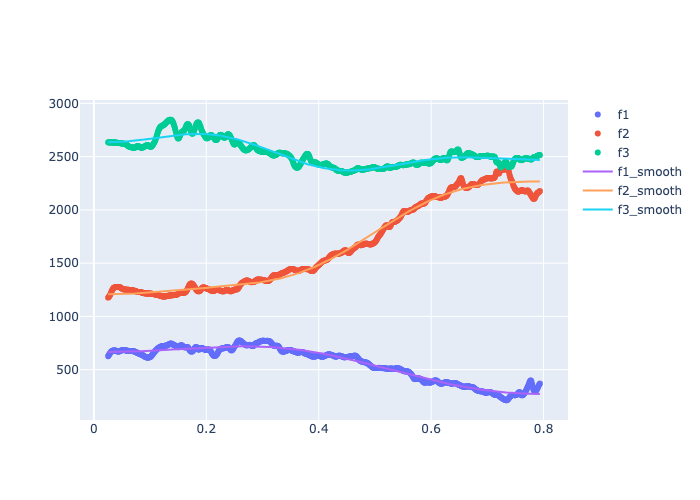

In [72]:
## static image
fig_bytes = fig.to_image(format = "png")
Image(fig_bytes)